In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import glob

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
directory = "/Users/erickwalker/Documents/Data_Science/Metis/Class_Projects/Project3_Classification/"

### Aggregate files into one DataFrame, and Pickle df

In [2]:
# If not using pickle file, run this code to combine all LendingClub files into one DataFrame. 
# Last two rows in each file contain extraneous info --> skipfooter = 2
path = "/Users/erickwalker/Documents/Data_Science/Metis/Class_Projects/Project3_Classification/LendingClub Data/Loan-level data"
files = glob.glob(path + "/*.csv")
all_data_df = pd.concat((pd.read_csv(file, engine="python", header=1, skipfooter=2) for file in files), 
                        ignore_index=True)

In [3]:
all_data_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,144899438,NaN,35000.0,35000.0,35000.0,36 months,14.47%,1204.23,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,144943072,NaN,5000.0,5000.0,5000.0,36 months,22.35%,191.86,D,D5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,144974419,NaN,10000.0,10000.0,10000.0,60 months,23.40%,284.21,E,E1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,145055546,NaN,17100.0,17100.0,17100.0,36 months,18.94%,626.30,D,D2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,145375687,NaN,4000.0,4000.0,4000.0,36 months,10.72%,130.43,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop columns and rows where all values are na. And where loan_status (our target) is unavailable
all_data_df = all_data_df[~(all_data_df["loan_status"].isnull() | all_data_df["loan_status"].isna())]\
.dropna(axis=1, how="all").dropna(axis=0, how="all")

In [8]:
with open(directory + "pickle files/LendingClub_all_df.pkl","wb") as picklefile:
    pickle.dump(all_data_df, picklefile)

## Some initial EDA

In [9]:
# View loan statuses to evaluate classification target
all_data_df["loan_status"].value_counts(normalize=True)

Fully Paid                                             0.517022
Current                                                0.339053
Charged Off                                            0.126033
Late (31-120 days)                                     0.007293
In Grace Period                                        0.007188
Late (16-30 days)                                      0.002230
Does not meet the credit policy. Status:Fully Paid     0.000715
Does not meet the credit policy. Status:Charged Off    0.000274
Default                                                0.000191
Name: loan_status, dtype: float64

In [10]:
# Remove wording "Does not meet the credit policy" and treat these loans normally
all_data_df.loc[all_data_df["loan_status"] == "Does not meet the credit policy. Status:Charged Off","loan_status"]\
="Charged Off"

all_data_df.loc[all_data_df["loan_status"] == "Does not meet the credit policy. Status:Fully Paid","loan_status"]\
="Fully Paid"

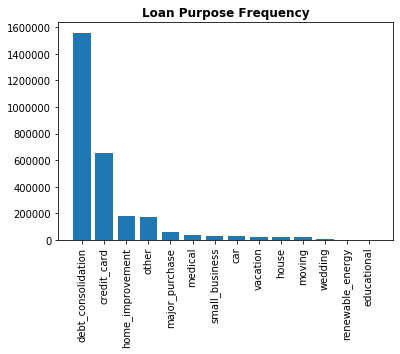

In [11]:
plt.bar(all_data_df["purpose"].value_counts().index,all_data_df["purpose"].value_counts()[0:])
plt.title("Loan Purpose Frequency", weight="bold")
plt.xticks(rotation=90);

In [12]:
# out_prncp and out_prncp_inv are similar
all_data_df[all_data_df["out_prncp"] != all_data_df["out_prncp_inv"]][["out_prncp","out_prncp_inv"]].head(10)

,out_prncp,out_prncp_inv
19,12193.47,12173.15
139,4691.84,4676.20
146,506.31,493.65
200,3803.30,3787.45
206,1865.38,1849.83
219,5459.96,5444.79
278,2325.29,2313.66
302,1918.71,1902.73
349,1838.39,1823.07
359,984.03,968.66


In [13]:
# funded_amnt and funded_amnt_inv are also very similar, total difference accounts for .09% of investor funded amnt
(all_data_df["funded_amnt"].sum() - all_data_df["funded_amnt_inv"].sum())/all_data_df["funded_amnt_inv"].sum()*100

0.09993817253162467

### Adjust and create new fields
* Convert **int_rate** field to float
* Create **Compound Annual Growth Rate (CAGR)** field
* Convert **issue_d** and **earliest_cr_line** to *date* type and **term** to *int* type
* Create **maturity_d** and **term_remaining** columns 

In [14]:
# Change interest rate to useable float
all_data_df["int_rate"] = all_data_df["int_rate"].apply(lambda x: float(x.replace("%","").strip())/100)

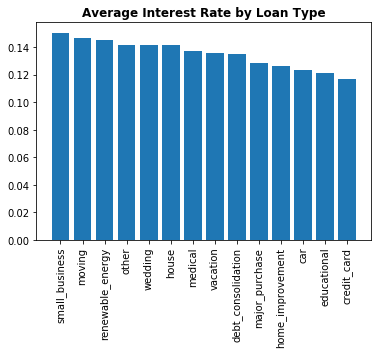

In [15]:
# Look at average interest rates by purpose
int_by_purpose = all_data_df.groupby("purpose")["int_rate"].mean().sort_values(ascending=False)
plt.bar(int_by_purpose.index,int_by_purpose.values)
plt.title("Average Interest Rate by Loan Type", weight="bold")
plt.xticks(rotation=90);

In [16]:
# Convert "issue_d" and "earliest_cr_line" to datetime and "term" to int.
all_data_df["issue_d"] = pd.to_datetime(all_data_df["issue_d"])
all_data_df["earliest_cr_line"] = pd.to_datetime(all_data_df["earliest_cr_line"])
all_data_df["term"] = all_data_df["term"].str.replace("months","").astype("int")

In [18]:
all_data_df.shape

(2778775, 149)

In [19]:
# View components of total_pymnt field
all_data_df[["total_rec_int","total_rec_late_fee","total_rec_prncp","recoveries","collection_recovery_fee",
            "total_pymnt"]].sample(10)

,total_rec_int,total_rec_late_fee,total_rec_prncp,recoveries,collection_recovery_fee,total_pymnt
620144,2190.11,0.0,18275.00,0.00,0.0000,20465.110006
687110,641.69,0.0,724.77,1653.62,297.6516,3020.080000
1782173,3433.00,0.0,5409.39,0.00,0.0000,8842.390000
1838384,802.02,0.0,1774.75,0.00,0.0000,2576.770000
678310,2409.25,0.0,16000.00,0.00,0.0000,18409.254832
510278,978.93,0.0,16000.00,0.00,0.0000,16978.933999
2582526,1676.62,0.0,12500.00,0.00,0.0000,14176.623856
594759,9035.39,0.0,14188.47,0.00,0.0000,23223.860000
2306184,1766.87,0.0,5204.88,1330.51,239.4918,8302.260000
1187095,8454.32,0.0,6732.03,0.00,0.0000,15186.350000


### Narrow df to only those loans that are Fully Paid, Defaulted, or Charged Off
* Also limit data to 2010-2016 time frame

In [279]:
final_status_loans_df["issue_d"].dt.year.value_counts().sort_index()

2010     12537
2011     21721
2012     53367
2013    134814
2014    235589
2015    397237
2016    400834
2017    286788
2018    179708
2019     59313
Name: issue_d, dtype: int64

In [27]:
final_status_loans_df = all_data_df[(all_data_df["issue_d"].dt.year.isin(range(2010,2017)))&
                                    (all_data_df["loan_status"].isin(["Fully Paid","Default","Charged Off"]))]

In [32]:
# Create CAGR field
final_status_loans_df["CAGR"] = (final_status_loans_df["total_pymnt"]/\
                               final_status_loans_df["funded_amnt"])**(1/(final_status_loans_df["term"]/12))-1

In [33]:
# Create maturity date field
final_status_loans_df["maturity_d"] = final_status_loans_df["issue_d"] + final_status_loans_df["term"].apply(lambda x: relativedelta(months=x))

/Users/erickwalker/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


In [37]:
# Create term remaining field
final_status_loans_df["term_remaining"] = (final_status_loans_df["maturity_d"] -\
                                           datetime.strptime("12-31-2019","%m-%d-%Y")).dt.days/30

In [41]:
final_status_loans_df[["issue_d","term","maturity_d","term_remaining","loan_status"]].head(10)

,issue_d,term,maturity_d,term_remaining,loan_status
0,2018-12-01,36,2021-12-01,23.366667,Fully Paid
1,2018-12-01,36,2021-12-01,23.366667,Fully Paid
7,2018-12-01,36,2021-12-01,23.366667,Fully Paid
14,2018-12-01,36,2021-12-01,23.366667,Fully Paid
17,2018-12-01,60,2023-12-01,47.700000,Fully Paid
21,2018-12-01,36,2021-12-01,23.366667,Charged Off
23,2018-12-01,60,2023-12-01,47.700000,Charged Off
25,2018-12-01,60,2023-12-01,47.700000,Fully Paid
27,2018-12-01,60,2023-12-01,47.700000,Fully Paid
29,2018-12-01,36,2021-12-01,23.366667,Fully Paid


In [42]:
final_status_loans_df["loan_status"].value_counts()

Fully Paid     1431776
Charged Off     349601
Default            531
Name: loan_status, dtype: int64

In [43]:
# Charged off rate by issue_d year
final_status_loans_df.groupby(final_status_loans_df["issue_d"].apply(lambda x: x.year))["loan_status"]\
.apply(lambda x:(x=="Charged Off").sum()/x.count())

issue_d
2010    0.140145
2011    0.151789
2012    0.161973
2013    0.155970
2014    0.177194
2015    0.199863
2016    0.195799
2017    0.222241
2018    0.235777
2019    0.154233
Name: loan_status, dtype: float64

In [45]:
# Create field indicating positive class (loan is in Default or Charged Off )
final_status_loans_df["charge_off"] = final_status_loans_df["loan_status"].isin(["Default","Charged Off"]).astype("int")

### Save progress to pickle file 

In [46]:
with open(directory + "pickle files/LendingClub_final_status_loans_df.pkl","wb") as picklefile:
    pickle.dump(final_status_loans_df, picklefile)

### Examine the return profiles of different loan purposes

In [49]:
# Rank loan types by percent of loans that are charged off or defaulted
final_status_loans_df.groupby("purpose")["charge_off"].mean().sort_values(ascending=False)

purpose
small_business        0.289407
moving                0.225119
house                 0.224728
educational           0.224138
renewable_energy      0.219835
medical               0.208217
debt_consolidation    0.207820
other                 0.203516
major_purchase        0.186895
vacation              0.182300
home_improvement      0.174559
credit_card           0.169241
car                   0.143490
wedding               0.123716
Name: charge_off, dtype: float64

In [99]:
# Charge off rates vary among loan purpose -- create dummy features for loan purpose
final_status_loans_df = pd.get_dummies(final_status_loans_df,columns=["purpose"])

In [50]:
# Loan-weighted CAGR by loan purpose
final_status_loans_df["wtd_CAGR"] = final_status_loans_df["CAGR"] * final_status_loans_df["funded_amnt"]

In [57]:
# Look at all loans
groupby_purpose = final_status_loans_df.groupby("purpose")[["out_prncp","wtd_CAGR","total_pymnt","total_rec_prncp","total_rec_int","funded_amnt"]].sum()
groupby_purpose["CAGR"] = groupby_purpose["wtd_CAGR"] / groupby_purpose["funded_amnt"]
groupby_purpose["pct_of_issued_out"] = groupby_purpose["out_prncp"] / groupby_purpose["funded_amnt"]
groupby_purpose["ROI"] = groupby_purpose["total_pymnt"] / groupby_purpose["funded_amnt"] - 1

In [58]:
groupby_purpose.sort_values(by="CAGR", ascending=True)

,out_prncp,wtd_CAGR,total_pymnt,total_rec_prncp,total_rec_int,funded_amnt,CAGR,pct_of_issued_out,ROI
purpose,,,,,,,,,
small_business,61510.63,-7.743608e+06,3.047338e+08,2.362052e+08,6.046309e+07,3.087642e+08,-0.025079,0.000199,-0.013053
house,29055.31,-3.786179e+06,1.580228e+08,1.307821e+08,2.396869e+07,1.608560e+08,-0.023538,0.000181,-0.017614
moving,22925.65,-1.954102e+06,1.010168e+08,8.162724e+07,1.702493e+07,1.012677e+08,-0.019296,0.000226,-0.002478
major_purchase,117821.90,-9.205436e+06,4.767258e+08,3.937287e+08,7.346246e+07,4.806068e+08,-0.019154,0.000245,-0.008075
vacation,26804.63,-1.431306e+06,7.841449e+07,6.495055e+07,1.188744e+07,7.844280e+07,-0.018246,0.000342,-0.000361
medical,35654.54,-3.546973e+06,1.950175e+08,1.598969e+08,3.112105e+07,1.947350e+08,-0.018214,0.000183,0.001451
renewable_energy,259.83,-2.043826e+05,1.251817e+07,1.007934e+07,2.158516e+06,1.235472e+07,-0.016543,0.000021,0.013229
other,360034.58,-1.356436e+07,1.093763e+09,8.874021e+08,1.836614e+08,1.078324e+09,-0.012579,0.000334,0.014318
educational,0.00,-7.353262e+03,8.505526e+05,7.108513e+05,1.321817e+05,8.212250e+05,-0.008954,0.000000,0.035712


### Return stats on charge_off loans

In [59]:
charge_off_groupby_purpose = final_status_loans_df[(final_status_loans_df["charge_off"]==1)] \
.groupby("purpose")[["out_prncp","wtd_CAGR","total_pymnt","total_rec_prncp","total_rec_int","funded_amnt"]].sum()

charge_off_groupby_purpose["CAGR"] = charge_off_groupby_purpose["wtd_CAGR"] / charge_off_groupby_purpose["funded_amnt"]
charge_off_groupby_purpose["pct_of_issued_out"] = charge_off_groupby_purpose["out_prncp"] / charge_off_groupby_purpose["funded_amnt"]
charge_off_groupby_purpose["ROI"] = charge_off_groupby_purpose["total_pymnt"] / charge_off_groupby_purpose["funded_amnt"] - 1

In [60]:
charge_off_groupby_purpose.sort_values(by="CAGR", ascending=True)

,out_prncp,wtd_CAGR,total_pymnt,total_rec_prncp,total_rec_int,funded_amnt,CAGR,pct_of_issued_out,ROI
purpose,,,,,,,,,
vacation,26804.63,-4.065246e+06,9.871519e+06,5.520326e+06,2.783256e+06,1.901258e+07,-0.213819,0.001410,-0.480790
renewable_energy,259.83,-6.581024e+05,1.607392e+06,8.428944e+05,4.852923e+05,3.118275e+06,-0.211047,0.000083,-0.484525
medical,35654.54,-9.929054e+06,2.344633e+07,1.226991e+07,7.192920e+06,4.710802e+07,-0.210772,0.000757,-0.502286
house,29055.31,-8.297063e+06,1.883488e+07,9.310794e+06,6.263427e+06,3.938472e+07,-0.210667,0.000738,-0.521772
educational,0.00,-3.805420e+04,1.069836e+05,7.235129e+04,2.727578e+04,1.827250e+05,-0.208259,0.000000,-0.414510
moving,22925.65,-5.452554e+06,1.345249e+07,6.937312e+06,4.162338e+06,2.657780e+07,-0.205154,0.000863,-0.493845
major_purchase,117821.90,-2.355809e+07,5.659598e+07,2.913485e+07,1.796348e+07,1.160130e+08,-0.203064,0.001016,-0.512158
other,360034.58,-5.067326e+07,1.366477e+08,6.988919e+07,4.415150e+07,2.608109e+08,-0.194291,0.001380,-0.476066
small_business,61510.63,-1.895452e+07,5.125299e+07,2.593955e+07,1.727832e+07,9.849855e+07,-0.192435,0.000624,-0.479657


### Return stats on paid off loans

In [62]:
paid_off_groupby_purpose = final_status_loans_df[(final_status_loans_df["charge_off"]==0)].groupby("purpose")\
[["out_prncp","wtd_CAGR","total_pymnt","total_rec_prncp","total_rec_int","funded_amnt"]].sum()

In [65]:
paid_off_groupby_purpose["CAGR"] = paid_off_groupby_purpose["wtd_CAGR"] / paid_off_groupby_purpose["funded_amnt"]
paid_off_groupby_purpose["pct_of_issued_out"] = paid_off_groupby_purpose["out_prncp"] / paid_off_groupby_purpose["funded_amnt"]
paid_off_groupby_purpose["ROI"] = paid_off_groupby_purpose["total_pymnt"] / paid_off_groupby_purpose["funded_amnt"] - 1

In [66]:
paid_off_groupby_purpose.sort_values(by="CAGR", ascending=False)

,out_prncp,wtd_CAGR,total_pymnt,total_rec_prncp,total_rec_int,funded_amnt,CAGR,pct_of_issued_out,ROI
purpose,,,,,,,,,
wedding,0.0,1.127811e+06,2.404671e+07,1.959455e+07,4.450819e+06,1.959455e+07,0.057557,0.0,0.227214
small_business,0.0,1.121092e+07,2.534808e+08,2.102657e+08,4.318477e+07,2.102657e+08,0.053318,0.0,0.205526
renewable_energy,0.0,4.537198e+05,1.091078e+07,9.236450e+06,1.673224e+06,9.236450e+06,0.049123,0.0,0.181274
educational,0.0,3.070094e+04,7.435690e+05,6.385000e+05,1.049059e+05,6.385000e+05,0.048083,0.0,0.164556
moving,0.0,3.498451e+06,8.756432e+07,7.468992e+07,1.286259e+07,7.468992e+07,0.046840,0.0,0.172371
other,0.0,3.710890e+07,9.571156e+08,8.175129e+08,1.395099e+08,8.175129e+08,0.045392,0.0,0.170765
debt_consolidation,0.0,5.475342e+08,1.447442e+10,1.228865e+10,2.184828e+09,1.228865e+10,0.044556,0.0,0.177869
vacation,0.0,2.633940e+06,6.854297e+07,5.943022e+07,9.104189e+06,5.943022e+07,0.044320,0.0,0.153335
medical,0.0,6.382082e+06,1.715712e+08,1.476270e+08,2.392813e+07,1.476270e+08,0.043231,0.0,0.162194


In [284]:
# CAGR for paid off loans 
final_status_loans_df[final_status_loans_df["charge_off"]==0]["wtd_CAGR"].sum() /\
final_status_loans_df[final_status_loans_df["charge_off"]==0]["funded_amnt"].sum()

0.048350019368707836

In [285]:
# CAGR for charged off loans 
final_status_loans_df[final_status_loans_df["charge_off"]==1]["wtd_CAGR"].sum() /\
final_status_loans_df[final_status_loans_df["charge_off"]==1]["funded_amnt"].sum()

-0.1381973024734858

### Compute the ratio of charge_off loan returns to non-charge_off loan returns
This will provide an indication of the relative importance of recall vs precision in the FBeta score used in model selection. *Numbers are taken from the last two cells above.*  
<br>
**Beta** = $$ \left|{\dfrac{CAGR_{charged off}}{CAGR_{fully paid}}}\right| = \left|\dfrac{-13.82}{4.83}\right| = 2.86 $$

In [11]:
beta = 2.86

In [72]:
# FICO scores are split into low - high range, take average of the two and drop low, high columns
final_status_loans_df["FICO_avg"] = (final_status_loans_df["fico_range_high"] + final_status_loans_df["fico_range_low"]) / 2
final_status_loans_df.drop(columns = ["fico_range_low","fico_range_high"],inplace=True)

In [73]:
# Make total FICO avg column based on both primary and secondary FICOs if fields are populated,
# else use primary FICO
final_status_loans_df["sec_FICO_avg"] = (final_status_loans_df["sec_app_fico_range_high"] + final_status_loans_df["sec_app_fico_range_low"])/2
final_status_loans_df["total_FICO_avg"] = ((final_status_loans_df["sec_FICO_avg"] + final_status_loans_df["FICO_avg"])/2)\
.combine_first(final_status_loans_df["FICO_avg"])

In [84]:
final_status_loans_df[["FICO_avg","sec_FICO_avg","total_FICO_avg"]].sample(10)

,FICO_avg,sec_FICO_avg,total_FICO_avg
1980025,687.0,NaN,687.0
2659298,692.0,NaN,692.0
836707,717.0,NaN,717.0
1752159,727.0,697.0,712.0
2570210,727.0,NaN,727.0
359159,717.0,NaN,717.0
803797,707.0,NaN,707.0
510155,707.0,NaN,707.0
1946780,662.0,NaN,662.0
280501,687.0,NaN,687.0


#### In this data verified loans are more likely to be charged off than un-verified loans
* Unsure if there's a reason for that, of it it's just noise
* Excluding from analysis for now

In [85]:
# Classifier for is_verified, to check if loan is verified or not
final_status_loans_df["is_verified"] = ((final_status_loans_df["verification_status"].isin(["Verified","Source Verified"])) |\
                               (final_status_loans_df["verification_status_joint"].isin(["Verified","Source Verified"])))\
                                .astype("int")

In [287]:
# Check if % of loans that have verified income are more charge_off than those that aren't
print("Percent of all loans that are charged off:",final_status_loans_df[final_status_loans_df["charge_off"]==1].shape[0]/\
      final_status_loans_df.shape[0])
print("Percent of verified loans that are charged off:",
      len(final_status_loans_df[(final_status_loans_df["is_verified"]==1) & (final_status_loans_df["charge_off"]==1)]) / 
      final_status_loans_df[final_status_loans_df["is_verified"]==1]["charge_off"].size)
print("Percent of un-verified loans that are charged off:",
      len(final_status_loans_df[(final_status_loans_df["is_verified"]==0) & (final_status_loans_df["charge_off"]==1)]) /
      final_status_loans_df[final_status_loans_df["is_verified"]==0]["charge_off"].size)

Percent of all loans that are charged off: 0.18663178618882748
Percent of verified loans that are charged off: 0.20588389796504578
Percent of un-verified loans that are charged off: 0.13896775193283636


In [288]:
# Percent of charge_off loans by verification status
final_status_loans_df[final_status_loans_df["charge_off"]==1]["verification_status_joint"].value_counts() / \
final_status_loans_df["verification_status_joint"].value_counts()

Not Verified    0.213559
Name: verification_status_joint, dtype: float64

#### Create "dti" feature: Ratio of monthly payments on debt (excluding mortgage and requested LC loan) to income
* Make one dti feature, combining dti and dti_joint

In [88]:
# Make debt to income (dti) column based on joint dti if field is populated, else use dti
final_status_loans_df["dti_clean"] = final_status_loans_df["dti_joint"].combine_first(final_status_loans_df["dti"])

In [89]:
# Check dti_clean for na / nulls
final_status_loans_df["dti_clean"].isnull().sum()

0

In [289]:
final_status_loans_df["dti_clean"].head()

2440474    13.77
2440452    19.10
2440451     5.59
2440450    21.45
2440449    22.95
Name: dti_clean, dtype: float64

#### Annual Income
* Make **final_income** column based on income that corresponds to application type
* Make income to installment ratio

In [92]:
final_status_loans_df["final_inc"] = final_status_loans_df["annual_inc"]
final_status_loans_df.loc[final_status_loans_df["application_type"]=="Joint App","final_inc"] = final_status_loans_df["annual_inc_joint"]

In [93]:
# Make monthly income column
final_status_loans_df["monthly_inc"] = final_status_loans_df["final_inc"]/12

In [94]:
# Monthly Income to Installment ratio
final_status_loans_df["install_to_inc"] = final_status_loans_df["installment"] / final_status_loans_df["monthly_inc"] * 100

In [95]:
# Monthly Income to total debt payments ratio
final_status_loans_df["total_dti"] = final_status_loans_df["dti_clean"] + final_status_loans_df["install_to_inc"]

In [290]:
final_status_loans_df["dti_bins"] = pd.cut(final_status_loans_df["total_dti"],5)

In [292]:
final_status_loans_df.groupby("dti_bins")["charge_off"].mean()

dti_bins
(-0.0361, 15.977]    0.121393
(15.977, 31.911]     0.173541
(31.911, 47.845]     0.245754
(47.845, 63.779]     0.315005
(63.779, 79.713]     0.387755
Name: charge_off, dtype: float64

#### Employment: See if relationship exists between Employment Length and Title and default rates

In [100]:
# Convert employment length to integer
final_status_loans_df["emp_length"] = pd.to_numeric(final_status_loans_df["emp_length"].str.replace(" year","").str \
                                           .replace("s","").str.replace("+","").str.replace("< ",""),
                                           errors="coerce")

In [101]:
# fill nas in emp_length
final_status_loans_df["emp_length"].fillna(final_status_loans_df["emp_length"].median(),inplace=True)

final_status_loans_df["emp_length"].isna().sum()/final_status_loans_df.shape[0]

0.0

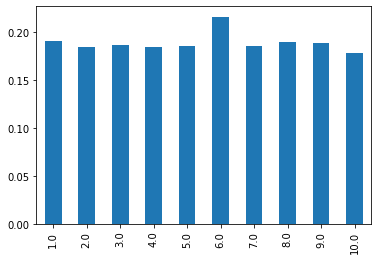

In [293]:
# Breakdown of charge_off small business loans by employment length
(final_status_loans_df[final_status_loans_df["charge_off"]==1]["emp_length"].value_counts()/final_status_loans_df["emp_length"].value_counts())\
.sort_index().plot.bar();

#### Weak correlation appears to exist between employment length and default rate

In [294]:
# % of all small business loans that are charged off
final_status_loans_df[final_status_loans_df["charge_off"]==1].shape[0]/final_status_loans_df["charge_off"].size

0.18663178618882748

In [295]:
# Clean up emp_title
final_status_loans_df["emp_title_clean"] = final_status_loans_df["emp_title"].str.strip().str.title().fillna("")

In [296]:
# See whether titles with "Manager" in them are correlated with charge offs 
final_status_loans_df[(final_status_loans_df["emp_title_clean"].str.contains("Manager")) & (final_status_loans_df["charge_off"]==1)].shape[0]\
/final_status_loans_df[(final_status_loans_df["emp_title_clean"].str.contains("Manager"))].shape[0]

0.18326013729586832

In [297]:
# See whether titles with "Owner" in them are correlated with charge offs
final_status_loans_df[(final_status_loans_df["emp_title_clean"].str.contains("Owner")) & (final_status_loans_df["charge_off"]==1)].shape[0]\
/final_status_loans_df[(final_status_loans_df["emp_title_clean"].str.contains("Owner"))].shape[0]

0.2172358823245254

In [298]:
# See whether employment in the medical industry correlates with charge offs
final_status_loans_df[final_status_loans_df["charge_off"]==1]["emp_title_clean"].apply(lambda x:any(i in ["Physician","Doctor","Dentist","Surgeon","Nurse"]\
                                                    for i in x.split())).sum()/\
final_status_loans_df["emp_title_clean"].apply(lambda x:any(i in ["Physician","Doctor","Dentist","Surgeon","Nurse"]\
                                                    for i in x.split())).sum()

0.16965736361338773

In [108]:
# Create new field -- one (1) if employment is related to the medical field 
final_status_loans_df["is_medical"] = final_status_loans_df["emp_title_clean"].apply(lambda x:\
                                                                   any(i in ["Physician","Doctor","Dentist",
                                                                             "Surgeon","Nurse"]\
                                                                       for i in x.split())).astype("int")

In [109]:
final_status_loans_df["is_manager"] = final_status_loans_df["emp_title_clean"].str.contains("Manager").astype("int").fillna(0)
final_status_loans_df["is_owner"] = final_status_loans_df["emp_title_clean"].str.contains("Owner").astype("int").fillna(0)

In [110]:
final_status_loans_df[["is_manager","is_owner","is_medical","emp_title_clean"]].head()

,is_manager,is_owner,is_medical,emp_title_clean
0,0,0,1,Staff Physician
1,0,0,0,Director Of Sales
7,0,0,0,Analyst
14,0,0,0,Administrative
17,0,0,0,Instructional Coordinator


### Some small business loans have a Description field -- may hold information about creditworthiness

In [111]:
final_status_loans_df["desc_clean"] = final_status_loans_df["desc"].fillna("")

In [112]:
# examine whether any relationship exists between length of description and default rates
final_status_loans_df["desc_length"] = final_status_loans_df["desc_clean"].apply(lambda x: len(str(x).split(" ")))

In [299]:
final_status_loans_df["desc_buckets"]=pd.cut(final_status_loans_df["desc_length"],10)

In [300]:
final_status_loans_df.groupby("desc_buckets")["charge_off"].mean()

desc_buckets
(-0.059, 106.9]    0.186833
(106.9, 212.8]     0.144789
(212.8, 318.7]     0.160907
(318.7, 424.6]     0.207317
(424.6, 530.5]     0.194030
(530.5, 636.4]     0.200000
(636.4, 742.3]     0.250000
(742.3, 848.2]     0.571429
(848.2, 954.1]     1.000000
(954.1, 1060.0]    0.500000
Name: charge_off, dtype: float64

In [301]:
final_status_loans_df["desc_length"].value_counts()

1      1138142
9         4850
13        3114
16        3067
17        3048
        ...   
487          1
485          1
482          1
469          1
875          1
Name: desc_length, Length: 565, dtype: int64

#### Takeaways for description length: 
1. Most SB loans lack any description -- could be problematic
2. There isn't much of a relationship between length and loan default rates. As you approach 600+ words default rates fall, but those account for a very small percent of the total population

**Next, try applying Sentiment Analysis**

In [116]:
analyser = SentimentIntensityAnalyzer()
final_status_loans_df["desc_sentiment"] = final_status_loans_df["desc_clean"].apply(lambda x: 9999 if type(x) == int else\
                                                                  analyser.polarity_scores(x))

In [117]:
final_status_loans_df["desc_compound_score"] = final_status_loans_df["desc_sentiment"].apply(lambda x: 9999 if type(x) ==\
                                                                           int else x["compound"])

In [118]:
final_status_loans_df[final_status_loans_df["desc_compound_score"]!=0][["desc_clean","desc_compound_score"]].sample(5)

,desc_clean,desc_compound_score
285485,Borrower added on 09/01/12 > Finish an exist...,0.4201
237224,Borrower added on 04/01/13 > consolodating c...,0.3818
2413089,Borrower added on 06/11/11 > I have much hig...,0.8020
182421,Borrower added on 08/27/13 > debt consolidat...,-0.3612
192276,Borrower added on 07/31/13 > to consolidate ...,0.5994


In [302]:
all_data_df["loan_status"].value_counts()

Fully Paid            1438676
Current                942153
Charged Off            350978
Late (31-120 days)      20265
In Grace Period         19974
Late (16-30 days)        6198
Default                   531
Name: loan_status, dtype: int64

In [303]:
final_status_loans_df["sentiment_buckets"] = pd.cut(final_status_loans_df["desc_compound_score"],15)

In [304]:
final_status_loans_df.groupby("sentiment_buckets")["charge_off"].mean()

sentiment_buckets
(-0.977, -0.843]     0.184211
(-0.843, -0.712]     0.191176
(-0.712, -0.58]      0.169759
(-0.58, -0.448]      0.154755
(-0.448, -0.317]     0.176486
(-0.317, -0.185]     0.157578
(-0.185, -0.0536]    0.159333
(-0.0536, 0.078]     0.189511
(0.078, 0.21]        0.140039
(0.21, 0.341]        0.169840
(0.341, 0.473]       0.151185
(0.473, 0.605]       0.148754
(0.605, 0.736]       0.144063
(0.736, 0.868]       0.147439
(0.868, 0.999]       0.150987
Name: charge_off, dtype: float64

#### Percent of cards with balances greater than 75% of limit

In [122]:
# Check for na and nulls
final_status_loans_df["percent_bc_gt_75"].isna().sum()

61660

In [123]:
final_status_loans_df["test_percent_bc_gt_75"] = final_status_loans_df["percent_bc_gt_75"].fillna(final_status_loans_df["percent_bc_gt_75"].mean())


In [126]:
# FICO score and percent_bc_gt_75 are correlated, fill na values with mode of value for given FICO score
final_status_loans_df["percent_bc_gt_75"].fillna(final_status_loans_df["percent_bc_gt_75"].mode(),inplace=True)


In [127]:
final_status_loans_df[["percent_bc_gt_75","FICO_avg","tax_liens","emp_length"]].corr()

,percent_bc_gt_75,FICO_avg,tax_liens,emp_length
percent_bc_gt_75,1.000000,-0.418944,-0.012288,0.029181
FICO_avg,-0.418944,1.000000,-0.058947,0.019347
tax_liens,-0.012288,-0.058947,1.000000,0.013479
emp_length,0.029181,0.019347,0.013479,1.000000


#### Home Ownership

In [128]:
# Check relationship between home_ownership status and charge_off rates
(final_status_loans_df[final_status_loans_df["charge_off"]==1]["home_ownership"].value_counts()\
                                         /final_status_loans_df["home_ownership"].value_counts()).sort_values(ascending=False)

OTHER       0.260000
RENT        0.228360
OWN         0.202718
ANY         0.189885
MORTGAGE    0.169621
NONE        0.152174
Name: home_ownership, dtype: float64

In [129]:
# Create home_owner variable, 1 if home_ownership = Mortgage or Own
final_status_loans_df["renter_or_other"] = final_status_loans_df["home_ownership"].isin(["RENT","OTHER"]).astype("int")

In [130]:
# Address # of mortgage accounts variable
final_status_loans_df["mort_acc_clean"] = final_status_loans_df["mort_acc"]
# If mort_acc is na, and loan is labeled MORTGAGE, set mort_acc to 1
final_status_loans_df.loc[(final_status_loans_df["mort_acc_clean"].isna()) &\
                                         (final_status_loans_df["home_ownership"]=="MORTGAGE"),"mort_acc_clean"]=1
# Otherwise, set nas to zero
final_status_loans_df.loc[final_status_loans_df["mort_acc_clean"].isna() ,"mort_acc_clean"]=0

#### Delinquencies

In [131]:
final_status_loans_df["mths_since_last_delinq"].isna().sum() 

903214

In [132]:
final_status_loans_df["mths_since_last_delinq_clean"] = final_status_loans_df["mths_since_last_delinq"].fillna(9999)

In [133]:
final_status_loans_df["mths_since_recent_bc"].isna().sum()

59983

In [134]:
final_status_loans_df["delinq_2yrs"].isna().sum() 

0

In [135]:
final_status_loans_df[final_status_loans_df["charge_off"]==1]["delinq_2yrs"].value_counts()/final_status_loans_df["delinq_2yrs"].value_counts()

0.0     0.193752
1.0     0.203969
2.0     0.212046
3.0     0.222130
4.0     0.221455
5.0     0.224700
6.0     0.213147
7.0     0.234524
8.0     0.218872
9.0     0.227273
10.0    0.208716
11.0    0.246575
12.0    0.271845
13.0    0.234848
14.0    0.229358
15.0    0.194444
16.0    0.279070
17.0    0.250000
18.0    0.172414
19.0    0.277778
20.0    0.230769
21.0    0.428571
22.0         NaN
23.0    0.500000
24.0         NaN
25.0    0.500000
26.0         NaN
27.0    1.000000
28.0         NaN
29.0         NaN
30.0         NaN
32.0         NaN
36.0    1.000000
39.0         NaN
42.0         NaN
Name: delinq_2yrs, dtype: float64

In [136]:
final_status_loans_df["delinq_amnt"].isna().sum() 

0

In [137]:
final_status_loans_df["mths_since_recent_bc_clean"] = final_status_loans_df["mths_since_recent_bc"].fillna(final_status_loans_df["mths_since_recent_bc"].mean())

In [138]:
# Check relationship delinquencies and charge_off rates
(final_status_loans_df[final_status_loans_df["charge_off"]==1]["mths_since_recent_bc_clean"].value_counts()\
                                         /final_status_loans_df["mths_since_recent_bc_clean"].value_counts()).sort_values()

263.0    0.035714
265.0    0.038462
300.0    0.047619
244.0    0.051282
290.0    0.052632
           ...   
612.0         NaN
615.0         NaN
616.0         NaN
639.0         NaN
656.0         NaN
Name: mths_since_recent_bc_clean, Length: 513, dtype: float64

#### Number of days since Earliest Credit Line 

In [144]:
final_status_loans_df["earliest_cr_line"] = pd.to_datetime(final_status_loans_df["earliest_cr_line"])

In [145]:
final_status_loans_df["earliest_cr_line_days"] = (final_status_loans_df["issue_d"] - final_status_loans_df["earliest_cr_line"]).dt.days

### Create is_joint feature (Joint loans are more likely to be charged off)
Reason behind that is not immediately clear

In [151]:
final_status_loans_df[final_status_loans_df["charge_off"]==1]["application_type"].value_counts()/\
final_status_loans_df["application_type"].value_counts()

Individual    0.194521
Joint App     0.251091
Name: application_type, dtype: float64

In [154]:
final_status_loans_df["is_joint"] = (final_status_loans_df["application_type"]=="Joint App").astype("int")

#### Derogatory Public Records

In [305]:
final_status_loans_df["pub_rec"].isna().sum() 

0

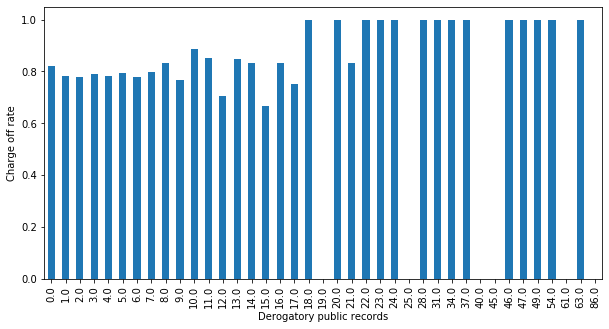

In [306]:
# Check relationship between derogatory public records and charge_off rates
plt.figure(figsize=(10,5))
(final_status_loans_df[final_status_loans_df["charge_off"]==0]["pub_rec"].value_counts()\
                                         /final_status_loans_df["pub_rec"].value_counts()).sort_index().plot.bar()
plt.ylabel("Charge off rate")
plt.xlabel("Derogatory public records");

#### Inquiries in the last 6 months

In [ ]:
final_status_loans_df["inq_last_6mths"].fillna(final_status_loans_df["inq_last_6mths"].mode(),inplace=True)

In [246]:
final_status_loans_df["inq_last_6mths"].isna().sum()

0

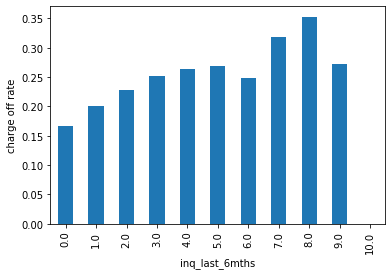

In [307]:
(final_status_loans_df[final_status_loans_df["charge_off"]==1]["inq_last_6mths"].value_counts()/\
final_status_loans_df["inq_last_6mths"].value_counts()).plot.bar()
plt.xlabel("inq_last_6mths")
plt.ylabel("charge off rate");

#### Tax Liens

In [180]:
final_status_loans_df["tax_liens"].isna().sum()

0

In [181]:
final_status_loans_df["tax_liens_clean"] = final_status_loans_df["tax_liens"].fillna(final_status_loans_df["tax_liens"].mean())

In [308]:
tax_liens = (final_status_loans_df[final_status_loans_df["charge_off"]==1]["tax_liens_clean"].value_counts()/\
final_status_loans_df["tax_liens_clean"].value_counts())

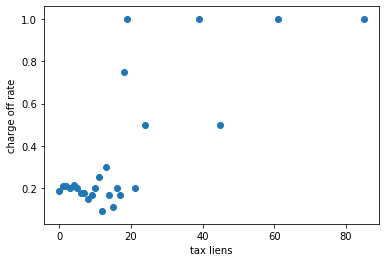

In [309]:
plt.scatter(tax_liens.index,tax_liens.values)
plt.xlabel("tax liens")
plt.ylabel("charge off rate");

#### Current balance to credit limit

In [194]:
final_status_loans_df["all_util_clean"] = final_status_loans_df["all_util"].fillna(
    final_status_loans_df["all_util"].mean())

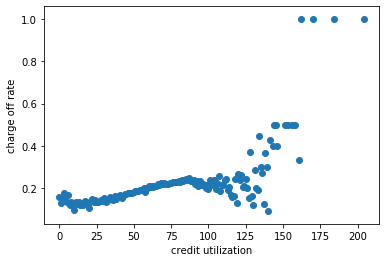

In [310]:
all_util = final_status_loans_df[final_status_loans_df["charge_off"]==1]["all_util_clean"].value_counts()/\
final_status_loans_df["all_util_clean"].value_counts()

plt.scatter(all_util.index,all_util.values)
plt.xlabel("credit utilization")
plt.ylabel("charge off rate");

### Subgrade

In [311]:
final_status_loans_df["subgrade_map"] = final_status_loans_df["sub_grade"].map(
    dict(zip(sorted(final_status_loans_df["sub_grade"].unique()),range(0,36))))

### Final Pickle

In [312]:
# Save pickle file
with open(directory + "pickle files/df_for_model.pkl","wb") as picklefile:
    pickle.dump(final_status_loans_df, picklefile)

In [3]:
# Open pickle file
with open(directory + "pickle files/df_for_model.pkl","rb") as picklefile:
    final_status_loans_df = pickle.load(picklefile)

In [313]:
final_status_loans_df.to_csv(directory + "LendingClub Data/csv/final_status_loans_df.csv")

### Declare Features and Target
Split df into train, validate, and test sets -- using 60% train, 20% validate, 20% test 

In [4]:
# Sort by issue_d to ensure time series consistency
final_status_loans_df = final_status_loans_df.sort_values(by="issue_d")

In [5]:
features = ["total_dti","total_FICO_avg","renter_or_other","mort_acc_clean","mths_since_last_delinq_clean",
            "emp_length","inq_last_6mths","is_joint","delinq_2yrs","earliest_cr_line_days","pub_rec",
            "is_medical","subgrade_map","tax_liens_clean","all_util_clean","purpose_credit_card",
            "purpose_debt_consolidation","purpose_other","purpose_car","purpose_vacation", "purpose_house",
            "purpose_home_improvement","purpose_major_purchase","purpose_small_business",
            "purpose_renewable_energy","purpose_medical","purpose_moving","purpose_wedding",
            "purpose_educational"]

train_val, validate, test = np.split(final_status_loans_df, [int(0.6*len(final_status_loans_df)), 
                                                                   int(0.8*len(final_status_loans_df))])

In [6]:
# Ensure all data has been included in split
train_val.shape[0] + validate.shape[0] + test.shape[0] == final_status_loans_df.shape[0]

True

In [7]:
X_train_val = train_val[features]
X_validate = validate[features]
X_test = test[features]

y_train_val = train_val["charge_off"]
y_validate = validate["charge_off"]
y_test = test["charge_off"]

In [8]:
print(f"X_train: {X_train_val.shape[0]}")
print(f"y_train: {y_train_val.shape[0]}")
print("")

print(f"X_validate: {X_validate.shape[0]}")
print(f"y_validate: {y_validate.shape[0]}")
print("")

print(f"X_test: {X_test.shape[0]}")
print(f"y_test: {y_test.shape[0]}")

X_train: 753659
y_train: 753659

X_validate: 251220
y_validate: 251220

X_test: 251220
y_test: 251220


In [9]:
# Scale data for Logistic Regression
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_validate_scaled = scaler.transform(X_validate)

### Use Cross-Validation to select model that maximizes F_Beta score
Looking to balance Precision with Recall

### Start by evaluating Logistic Regression model

In [12]:
# Calculate FBeta score on validation data using class_weight found with GridSearchCV
fbeta = make_scorer(fbeta_score, beta=beta)

gsc_lr = GridSearchCV(LogisticRegression(random_state=4), 
                   param_grid={"class_weight": [{0: weight, 1: 1-weight} for weight in np.arange(0.1,1,0.1)]},
                  scoring = fbeta).fit(X_train_val_scaled,y_train_val)
gsc_lr.best_params_

{'class_weight': {0: 0.1, 1: 0.9}}

In [13]:
logistic_regression = LogisticRegression(random_state=4, class_weight = gsc_lr.best_params_["class_weight"])
logistic_regression.fit(X_train_val_scaled, y_train_val)

threshold = 0.50
y_proba_lr = logistic_regression.predict_proba(X_validate_scaled)[:,1]

y_preds_lr = (y_proba_lr > threshold).astype(int)

In [14]:
def plot_ROC(y_pred, y_prob, y_test, title):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{title}")

    x = np.linspace(0,1,1000)
    plt.plot(x, x, linestyle = "--")

    plt.title(title, weight="bold")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(directory + "/Graphs/" + title +".png", dpi=300)
    
    print(f"F_{beta:0.2f} Score: {fbeta_score(y_test, y_pred, beta=3):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

F_2.86 Score: 0.611
Recall: 0.740
Precision: 0.238
ROC AUC: 0.566
Accuracy: 0.469


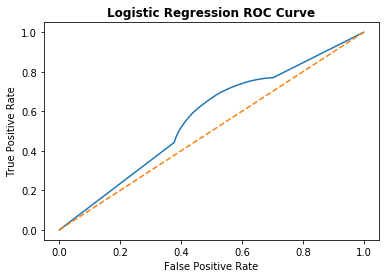

In [15]:
plot_ROC(y_preds_lr, y_proba_lr, y_validate, "Logistic Regression ROC Curve")

In [16]:
# Create heat map of confusion matrix
# Confusion Matrix, Precision, and Recall scores
def create_confusion_matrix(y_test, y_pred, title):
    c_matrix = confusion_matrix(y_test, y_pred, normalize="all")
    plt.figure()
    sns.heatmap(c_matrix,cmap=plt.cm.Blues, annot=True, square=True,
    xticklabels=['Fully Paid', 'Charged Off'],
    yticklabels=['Fully Paid', 'Charged Off'])
    plt.title(title,weight="bold")
    plt.xlabel('prediction',weight="bold",labelpad=10)
    plt.ylabel('actual',weight="bold",labelpad=10)

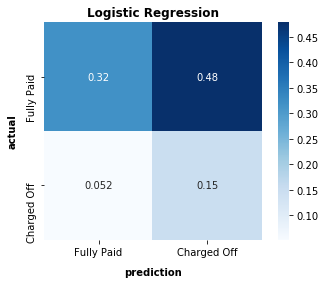

In [17]:
fig = create_confusion_matrix(y_validate, y_preds_lr, "Logistic Regression")
plt.savefig(directory + 'Graphs/Log_CM.png',dpi=300);

### Test Random Forest on validation set 

In [19]:
# Randomized search to find hyperparameters that maximize FBeta

# Number of trees in random forest
rscv_params = {"n_estimators" : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
          # Number of features to consider at every split
          "max_features" : ["auto", "sqrt"],
          # Maximum number of levels in tree
          "max_depth" : [int(x) for x in np.linspace(1, 100, num = 11)],
          # Minimum number of samples required to split a node
          "min_samples_split" : range(2,11),
          # Minimum number of samples required at each leaf node
          "min_samples_leaf" : range(1,6),
          "class_weight":[{0: weight, 1: 1-weight} for weight in np.arange(0.1,1,0.1)]}

fbeta = make_scorer(fbeta_score, beta=beta)

rscv = RandomizedSearchCV(RandomForestClassifier(random_state=4), rscv_params, cv=3, scoring=fbeta)
rscv.fit(X_train_val, y_train_val)
rscv.best_params_

In [20]:
rscv.best_params_

{'n_estimators': 500,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 0.1, 1: 0.9}}

In [21]:
gscv_params = {"n_estimators" : [400,500,600],
          # Minimum number of samples required to split a node
          "min_samples_split" : [2,3,5],
          # Minimum number of samples required at each leaf node
          "min_samples_leaf" : [4,5,6,7],
          # Number of features to consider at every split
          "max_features" : ["sqrt"],
          # Maximum number of levels in tree
          "max_depth" : [5,10,25,50],
          "class_weight":[{0: 0.1, 1: 0.9},{0: 0.2, 1: 0.8},{0: 0.3, 1: 0.7}]
              }
               
gscv_rf = GridSearchCV(RandomForestClassifier(random_state=4), param_grid = gscv_params, scoring=fbeta, cv=3)
gscv_rf.fit(X_train_val, y_train_val)
gscv_rf.best_params_

KeyboardInterrupt: 

In [176]:
random_forest = RandomForestClassifier(random_state = 4, n_estimators = gscv_rf.best_params_["n_estimators"],
                                       min_samples_split = gscv_rf.best_params_["min_samples_split"], 
                                       min_samples_leaf = gscv_rf.best_params_["min_samples_leaf"],
                                      max_features = gscv_rf.best_params_["max_features"],
                                      max_depth = gscv_rf.best_params_["max_depth"],
                                      class_weight = gscv_rf.best_params_["class_weight"])

random_forest.fit(X_train_val, y_train_val);

F_2.84 Score: 0.732
Recall: 0.995
Precision: 0.216
ROC AUC: 0.654
Accuracy: 0.241


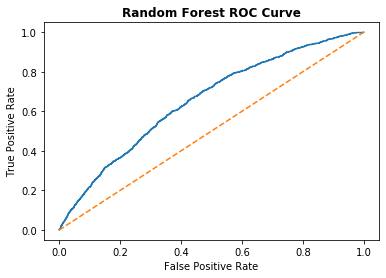

In [193]:
threshold = 0.23
y_proba_rf = random_forest.predict_proba(X_validate)[:,1]
y_preds_rf = (y_proba_rf > threshold).astype(int)

plot_ROC(y_preds_rf, y_proba_rf, y_validate, "Random Forest ROC Curve")

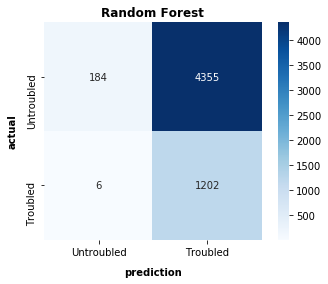

In [202]:
fig = create_confusion_matrix(y_validate, y_preds_rf, "Random Forest")
plt.savefig(directory + 'Graphs/RF_CM.png',dpi=300);

### Logistic Regression has highest FBeta sore
Run the model again, now training on entire train + validation set

In [197]:
X_train = pd.concat([X_train_val,X_validate])
y_train = pd.concat([y_train_val,y_validate])

# Scale data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [198]:
logistic_regression = LogisticRegression(random_state=4, class_weight = gsc_lr.best_params_["class_weight"])
logistic_regression.fit(X_train_scaled,y_train)

threshold = 0.47
y_proba_lr = logistic_regression.predict_proba(X_test_scaled)[:,1]

y_preds_lr = (y_proba_lr > threshold).astype(int)

F_2.84 Score: 0.488
Recall: 0.996
Precision: 0.087
ROC AUC: 0.686
Accuracy: 0.131


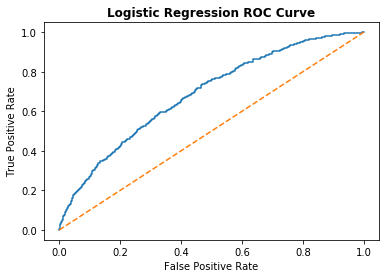

In [199]:
plot_ROC(y_preds_lr, y_proba_lr, y_test, "Logistic Regression ROC Curve")

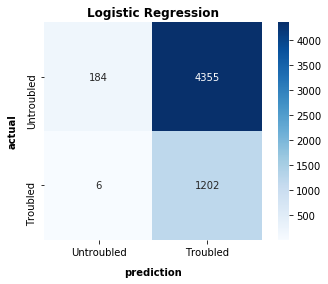

In [201]:
fig = create_confusion_matrix(y_validate, y_preds_rf, "Logistic Regression")
plt.savefig(directory + 'Graphs/LR_CM_Final.png',dpi=300);

### Interpretation of Logistic Regression Coefficients

In [204]:
lr_coef = dict(sorted(zip(X_train.columns,logistic_regression.coef_[0]),key=lambda x: x[1],reverse=False))

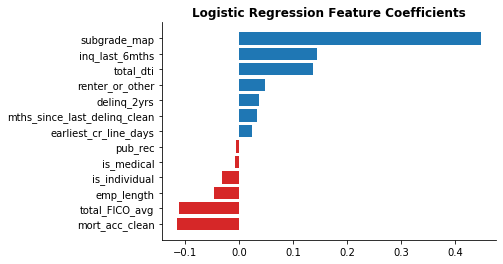

In [205]:
plt.barh(list(lr_coef.keys()),list(lr_coef.values()), 
         color=((pd.Series(list(lr_coef.values()))>0).map({True:"tab:blue",False:"tab:red"})))
plt.title("Logistic Regression Feature Coefficients",weight="bold")
sns.despine(top=True, right=True)
plt.savefig(directory + "/Graphs/LogReg_Coefficients.png",dpi=300);

In [207]:
for key in lr_coef:
    print(f"""For a one stdev increase in {key}, the odds a loan becomes charge_off change by: {(math.exp(lr_coef[key])-1)*100:.2f}%""")
    print("")

For a one stdev increase in mort_acc_clean, the odds a loan becomes troubled change by: -10.87%

For a one stdev increase in total_FICO_avg, the odds a loan becomes troubled change by: -10.50%

For a one stdev increase in emp_length, the odds a loan becomes troubled change by: -4.47%

For a one stdev increase in is_individual, the odds a loan becomes troubled change by: -3.13%

For a one stdev increase in is_medical, the odds a loan becomes troubled change by: -0.66%

For a one stdev increase in pub_rec, the odds a loan becomes troubled change by: -0.63%

For a one stdev increase in earliest_cr_line_days, the odds a loan becomes troubled change by: 2.41%

For a one stdev increase in mths_since_last_delinq_clean, the odds a loan becomes troubled change by: 3.38%

For a one stdev increase in delinq_2yrs, the odds a loan becomes troubled change by: 3.74%

For a one stdev increase in renter_or_other, the odds a loan becomes troubled change by: 4.97%

For a one stdev increase in total_dti, 

### Testing: Does Using the Model's Predictions Improve Investment Performance?

In [209]:
# Add loan id
#X_train = train[["id"] + features]
X_test = test[["id"] + features]

In [211]:
X_test["y_preds_lr"] = y_preds_lr

In [214]:
print(f"Number of loans predicted to be charge_off: {y_preds_lr.sum()}, out of {y_test.sum()} actual charge_off")

Number of loans predicted to be troubled: 5469, out of 479 actual troubled


In [254]:
final_status_loans_df_join = final_status_loans_df.join(X_test[["id","y_preds_lr"]].set_index("id"), on="id", rsuffix="_test")

In [270]:
final_status_loans_df["total_pymnt_inv"].sum()/final_status_loans_df["funded_amnt_inv"].sum()

-0.161742303370489

In [256]:
(final_status_loans_df_join[final_status_loans_df_join["id"].isin(X_test["id"])]["wtd_CAGR"].sum() /\
 final_status_loans_df_join[(final_status_loans_df_join["id"].isin(X_test["id"]))]["funded_amnt"].sum())*100

-26.65383460947047

In [274]:
final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)]["loan_status"].value_counts()

Current            220
Fully Paid          52
In Grace Period      4
Charged Off          2
Name: loan_status, dtype: int64

In [ ]:
(final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)]["wtd_CAGR"].sum()/\
                               final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)]["funded_amnt"].sum())*100

In [262]:
# Loan-weighted CAGR by loan purpose
final_status_loans_df_join["wtd_CAGR"] = final_status_loans_df_join["CAGR"] * final_status_loans_df_join["funded_amnt"]

cagr_all_small = (final_status_loans_df_join["wtd_CAGR"].sum()/final_status_loans_df_join["funded_amnt"].sum())*100

cagr_uncharge_off_pred_small = (final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)]["wtd_CAGR"].sum()/\
                               final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)]["funded_amnt"].sum())*100

cagr_all_test = (final_status_loans_df_join[final_status_loans_df_join["id"].isin(X_test["id"])]["wtd_CAGR"].sum()/\
                 final_status_loans_df_join[(final_status_loans_df_join["id"].isin(X_test["id"]))]["funded_amnt"].sum())*100

# Look at all matured loans
print(f"CAGR for all small business loans: {cagr_all_small:.3f}")
print(f"CAGR for all SB loans in test set: {cagr_all_test:.3f}")
print(f"CAGR for SB loans model predicted to be uncharge_off: {cagr_uncharge_off_pred_small:.3f}")
print(f"Delta between all small bus and model predicted uncharge_off: {cagr_uncharge_off_pred_small-cagr_all_small:.3f}")
print(f"Delta between test loans and model predicted uncharge_off: {cagr_uncharge_off_pred_small-cagr_all_test:.3f}")

CAGR for all small business loans: -7.977
CAGR for all SB loans in test set: -26.654
CAGR for SB loans model predicted to be untroubled: -26.468
Delta between all small bus and model predicted untroubled: -18.491
Delta between test loans and model predicted untroubled: 0.186


In [257]:
# Loan-weighted CAGR by loan purpose
final_status_loans_df_join["wtd_CAGR"] = final_status_loans_df_join[final_status_loans_df_join["term_remaining"]<=0]["CAGR"] *\
                                final_status_loans_df_join[final_status_loans_df_join["term_remaining"]<0]["funded_amnt"]

cagr_all_small = (final_status_loans_df_join[final_status_loans_df_join["term_remaining"]<=0]["wtd_CAGR"].sum() /\
                  final_status_loans_df_join[final_status_loans_df_join["term_remaining"]<=0]["funded_amnt"].sum())*100

cagr_uncharge_off_pred__small = (final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)&(final_status_loans_df_join["term_remaining"]\
                        <=0)]["wtd_CAGR"].sum()/final_status_loans_df_join[(final_status_loans_df_join["y_preds_lr"]==0)&
                                                                  (final_status_loans_df_join["term_remaining"]<=0)]["funded_amnt"].sum())*100

cagr_all_test = (final_status_loans_df_join[(final_status_loans_df_join["id"].isin(X_test["id"])) &
                                   (final_status_loans_df_join["term_remaining"]<=0)]["wtd_CAGR"].sum() /\
                 final_status_loans_df_join[(final_status_loans_df_join["id"].isin(X_test["id"])) & 
                                   (final_status_loans_df_join["term_remaining"]<=0)]["funded_amnt"].sum())*100

# Look at all matured loans
print(f"CAGR for all small business loans: {cagr_all_small:.3f}")
print(f"CAGR for all SB loans in test set: {cagr_all_test:.3f}")
print(f"CAGR for SB loans model predicted to be uncharge_off: {cagr_uncharge_off_small:.3f}")
print(f"Delta between all small bus and model predicted uncharge_off: {cagr_uncharge_off_small-cagr_all_small:.3f}")
print(f"Delta between test loans and model predicted uncharge_off: {cagr_uncharge_off_small-cagr_all_test:.3f}")

CAGR for all small business loans: -0.142
CAGR for all SB loans in test set: nan


/Users/erickwalker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/erickwalker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


NameError: name 'cagr_untroubled_small' is not defined

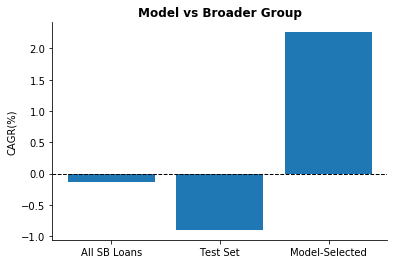

In [482]:
# Plot return differences
plt.bar(["All SB Loans", "Test Set", "Model-Selected"],[cagr_all_small, cagr_all_test, cagr_uncharge_off_small])
plt.ylabel("CAGR(%)")
plt.title("Model vs Broader Group",weight="bold")
plt.axhline(linewidth=1, xmin=0, xmax=1, color='k', linestyle='--')
sns.despine(top=True, right=True)
plt.savefig(directory + 'Graphs/cagr_comp.png',dpi=300);


In [119]:
small_bus_fa = final_status_loans_df_join[final_status_loans_df_join["term_remaining"]<=0]["funded_amnt"].sum()
small_bus_approved_fa = final_status_loans_df_join[(final_status_loans_df_join["y_pred"]==0)&(final_status_loans_df_join["term_remaining"]<=0)]["funded_amnt"].sum()
print(f"Funded amounts, all small business loans: {small_bus_fa}")
print(f"Funded amounts, small business loans approved by classifier: {small_bus_approved_fa}")
print(f"% of Total: {small_bus_approved_fa/small_bus_fa*100:0.3f}")


Funded amounts, all small business loans: 193137375.0
Funded amounts, small business loans approved by classifier: 3777825.0
% of Total: 1.956
